In [1]:
import pandas as pd
import os
from tqdm import tqdm
import argparse
import yaml
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import bokeh

from utils import *
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
# General info dataframe
filepath_measurements_info = "/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/2_analysis/sd_tweezers_info_1.csv"
results_dir = '/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/3_plots/'

df_general_info = pd.read_csv(filepath_measurements_info, delimiter=';', encoding='utf-8')
df_general_info.head()

save_to_server = True

[ 98 378]
Shape of the images array: (300, 695, 665, 3)


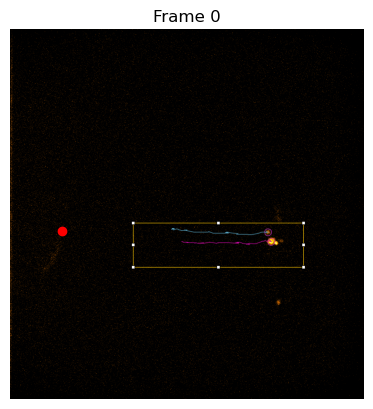

In [3]:
filepath = '/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/1_measurements/20240523/20240523_s01p01t01/TrackMate capture of 20240523_s01p01t01_1_5sON_15sOFF_1000mV-1.tif'

tip = df_general_info.loc[df_general_info['trackmate_file'].str.contains('20240523_s01p01t01_1_5sON_15sOFF'), ['tip_x', 'tip_y']].values[0]
print(tip)
# Load the time series TIFF file
images = tifffile.imread(filepath)

# Check the shape of the images array (T, Z, Y, X) or (T, Y, X) depending on the data
print("Shape of the images array:", images.shape)

# Plot the first frame of the time series
plt.figure()
plt.imshow(images[0], cmap='gray')
plt.plot(tip[0], tip[1], 'ro')
plt.title('Frame 0')
plt.axis('off')
plt.show()

In [4]:
df_general_info = df_general_info.sort_values(by='trackmate_file')
df_general_info.head(5)


,trackmate_file,MTs,first_pulse (frame),last_pulse_start (frame),t_on (frame),t_off (frame),tip_x,tip_y,calibration (mV),bead_type,time_interval (s),comments
0,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,131,251,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
1,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,169,249,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
2,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,13,653,10,30,53,314,1000,2.8 um myc dyna passivated PEG,0.5,NaN
3,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,11,611,10,30,57,360,1000,2.8 um myc dyna passivated PEG,0.5,"one bead stuck during pulses 7,8,9,10"
4,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,11,531,10,30,82,254,1000,2.8 um myc dyna passivated PEG,0.5,NaN


   MT_status       mean        std     median         q1         q3
16         y   1.544304   0.701289   1.382776   1.086133   2.001636
15         y   2.705329   1.523875   2.087787   1.614393   3.582265
14         y   0.918280   0.377578   0.802977   0.675505   1.111218
13         y   1.825662   0.422884   1.741516   1.569530   2.095377
12         y   2.057538   0.884465   1.839195   1.456207   2.434131
11         y   1.698946   0.585018   1.618740   1.227159   1.874706
10         y   2.292318   0.957467   1.890583   1.629026   2.706068
9          n  15.986614  10.273113  15.446894   9.310039  19.984856
0          n   6.982351   3.655017   6.982351   5.690107   8.274594
1          n   7.982034   5.966747   6.734102   3.070055  11.601074
7          n  12.144549  12.737463   6.115292   3.720630  16.365146
6          n  10.002323   5.574402   8.179102   6.866924  10.757274
5          n   8.123075   7.172362   5.711402   2.536397  11.689524
4          n   5.960018   2.916320   4.756620   

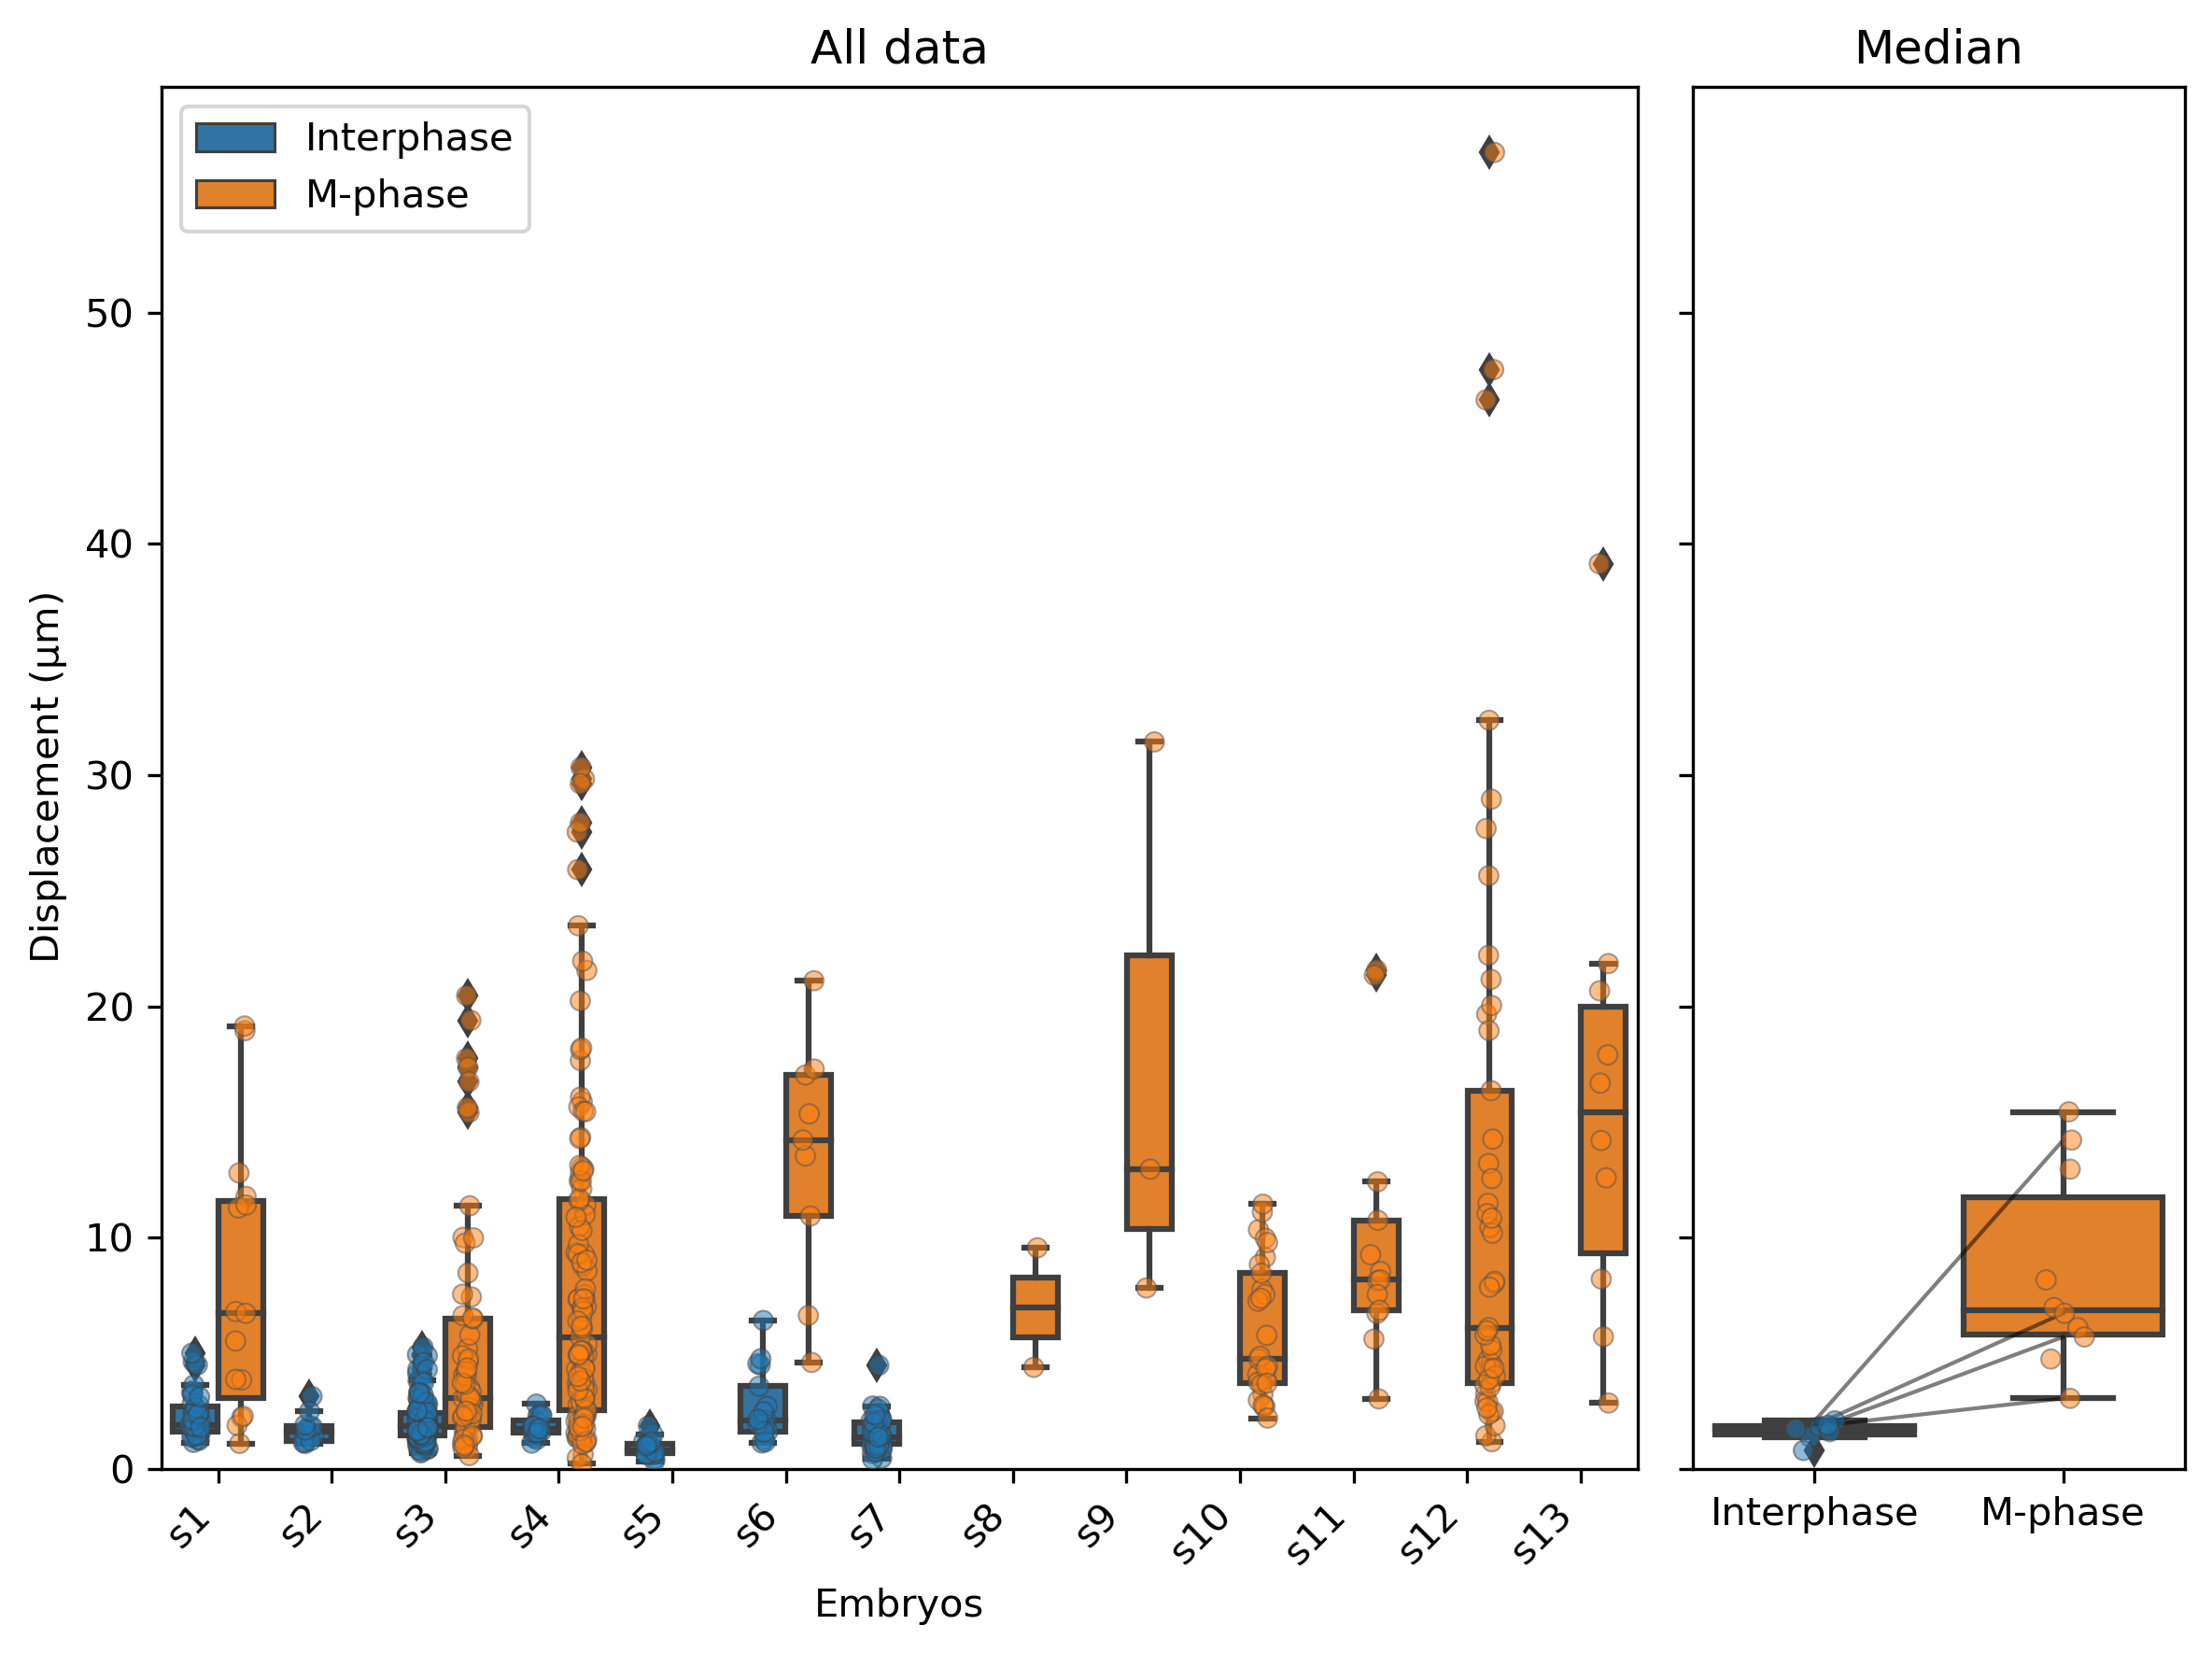

   MT_status      mean       std    median        q1        q3
16         y -0.678942  0.316498 -0.692005 -0.924355 -0.417660
15         y -0.683615  0.385930 -0.593880 -0.841986 -0.439222
14         y -0.480801  0.166497 -0.461395 -0.541467 -0.390905
13         y -0.687649  0.258630 -0.671022 -0.857636 -0.492244
12         y -0.649686  0.313675 -0.614208 -0.810904 -0.434509
11         y -0.714353  0.116316 -0.655539 -0.780793 -0.639262
10         y -0.739011  0.248116 -0.687173 -0.869302 -0.575178
9          n -1.162697  1.003525 -0.672210 -1.828274 -0.429342
0          n -0.348732  0.349861 -0.348732 -0.472426 -0.225037
1          n -1.132985  0.590806 -0.856505 -1.463826 -0.727758
7          n -0.962684  0.474613 -0.952346 -1.298853 -0.735359
6          n -0.611297  0.447552 -0.487076 -0.942003 -0.210218
5          n -0.872480  0.518352 -0.820944 -1.201876 -0.519272
4          n -0.907642  0.328932 -0.878330 -1.063754 -0.655316
3          n -0.783261  0.450263 -0.761746 -0.973068 -0

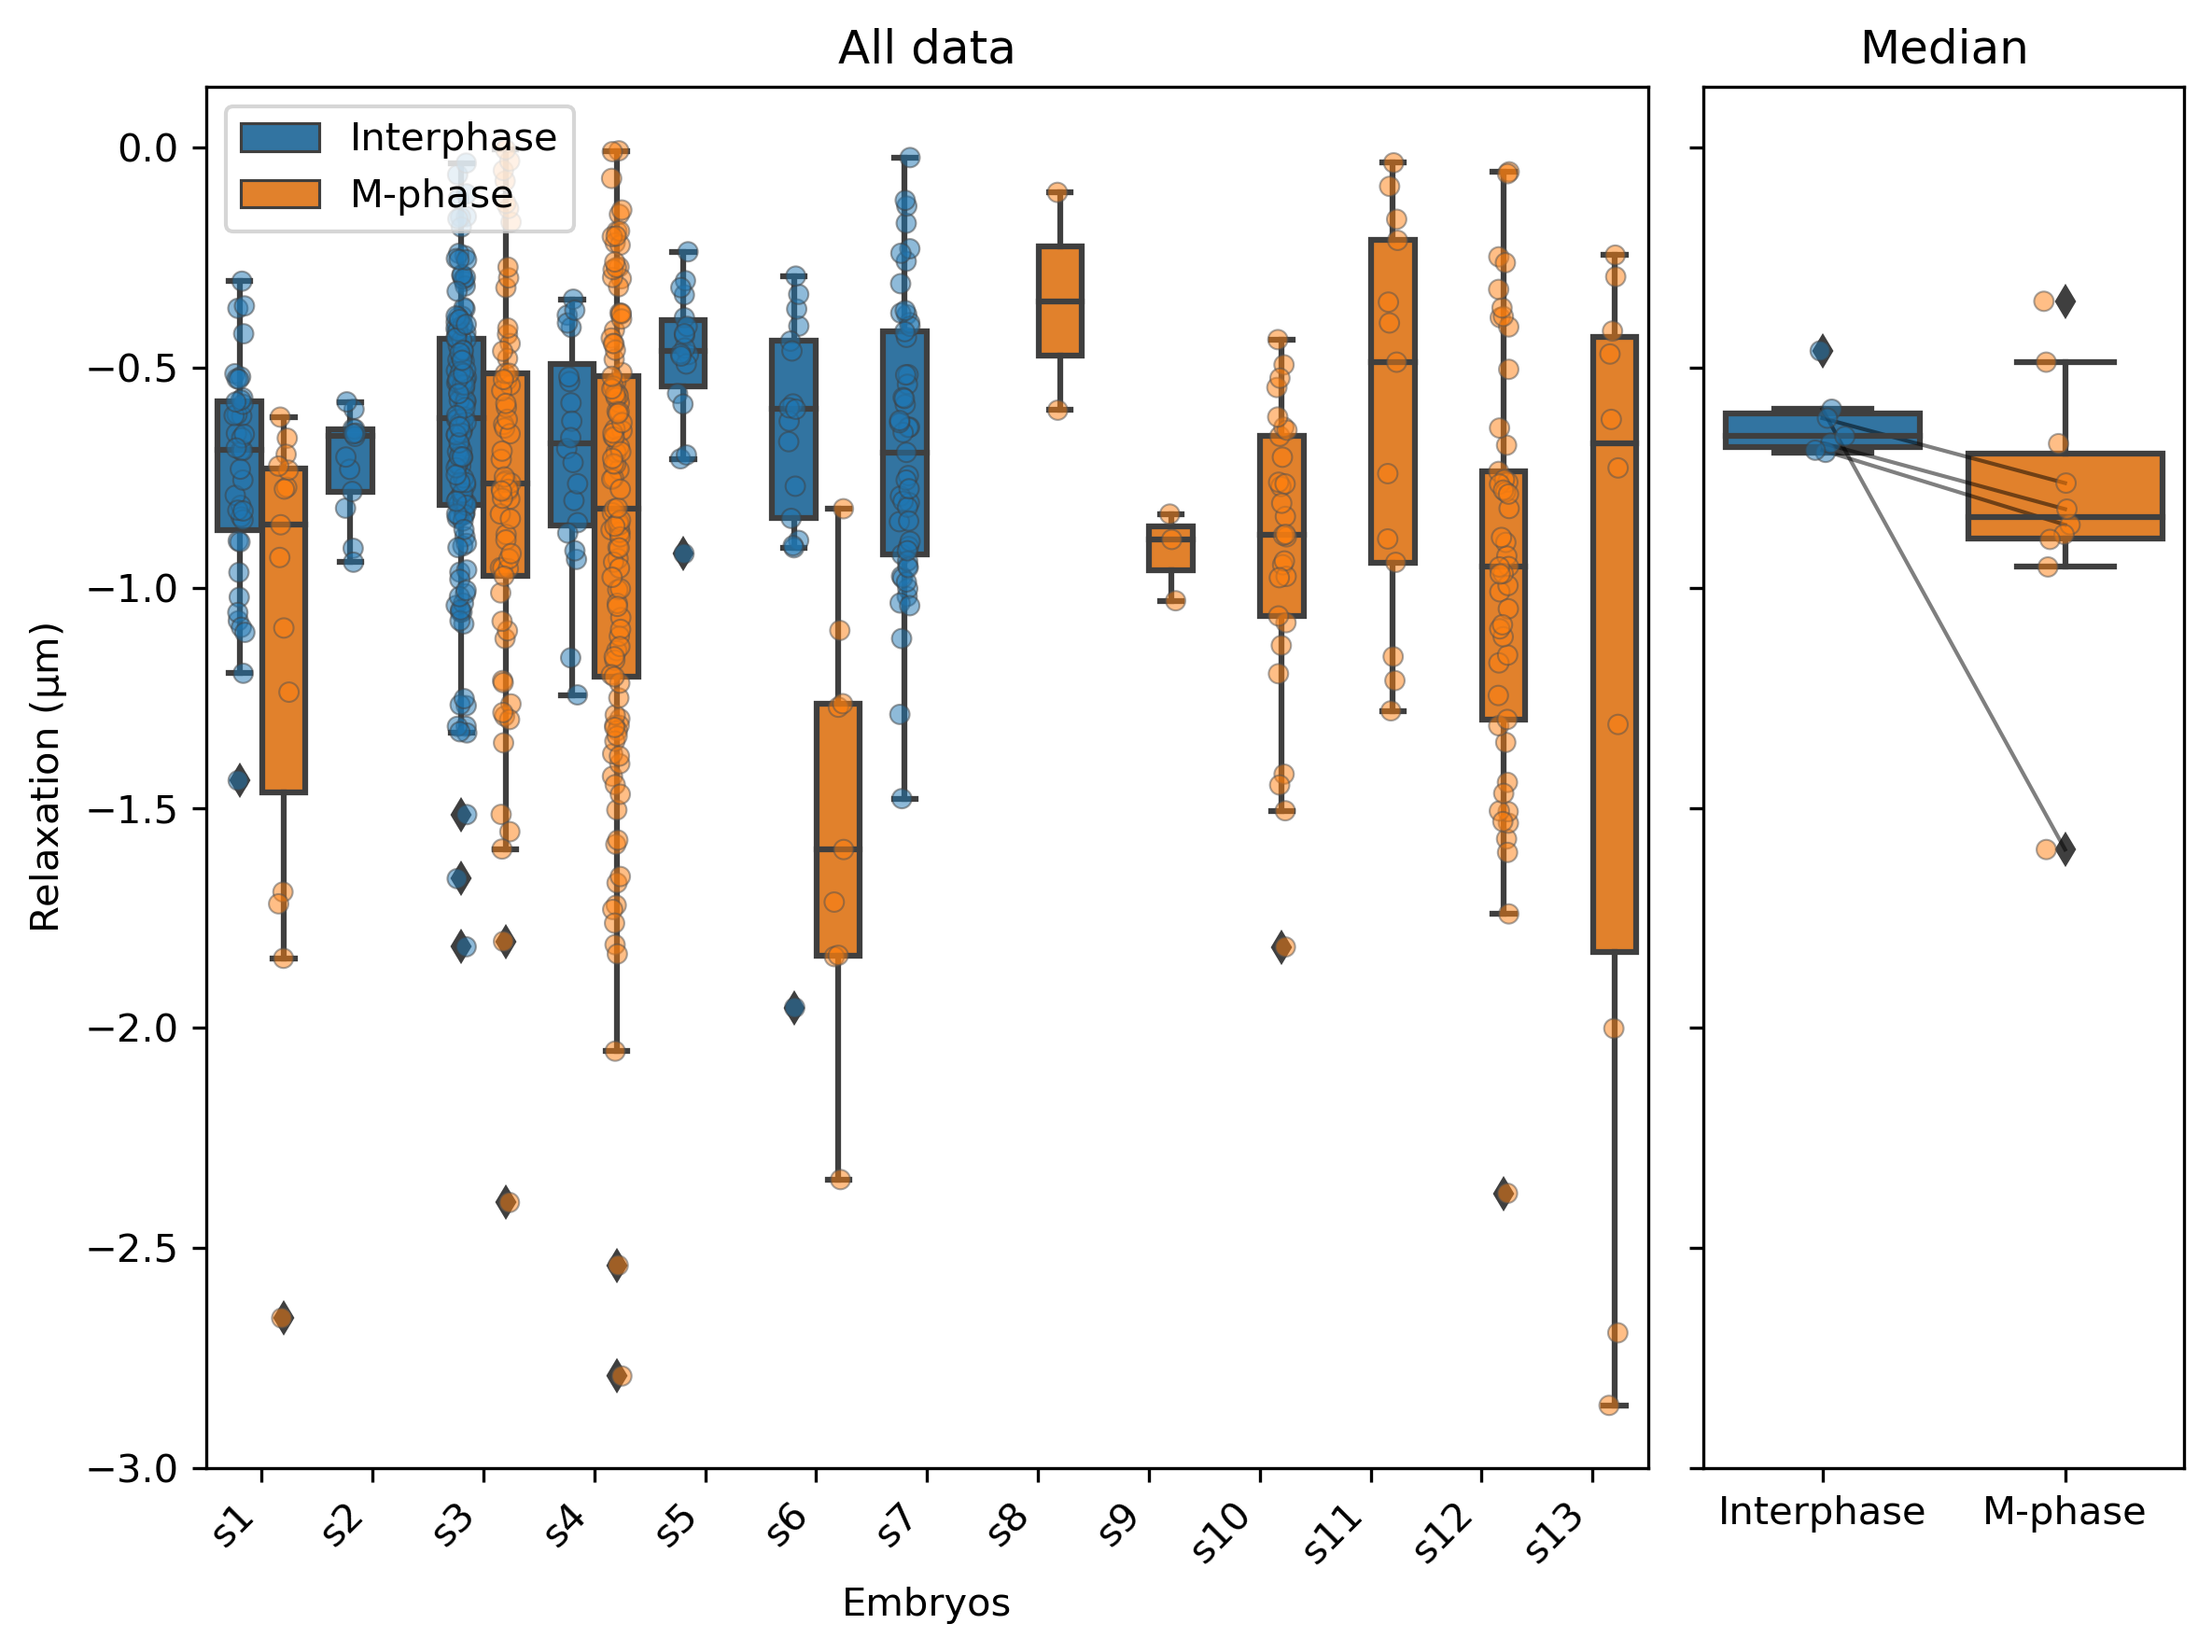

   MT_status      mean       std    median        q1        q3
16         y  0.034436  0.014214  0.030248  0.025788  0.041200
15         y  0.129718  0.082859  0.101977  0.072954  0.166967
14         y  0.038958  0.014999  0.036165  0.029724  0.046829
13         y  0.019152  0.004967  0.018668  0.014839  0.022811
12         y  0.030189  0.013834  0.028106  0.020602  0.036348
11         y  0.036298  0.011489  0.035640  0.026580  0.039995
10         y  0.078010  0.030510  0.065321  0.057834  0.090905
9          n  0.867852  0.648247  0.828993  0.439731  1.019771
0          n  0.125004  0.069348  0.125004  0.100486  0.149522
1          n  0.175189  0.138757  0.126437  0.092774  0.256863
7          n  0.251247  0.231376  0.131354  0.078620  0.385535
6          n  0.191612  0.114058  0.152029  0.134211  0.180445
5          n  0.094033  0.086707  0.062934  0.029620  0.139486
4          n  0.080844  0.044287  0.067207  0.049173  0.114970
3          n  0.047434  0.049359  0.027215  0.012550  0

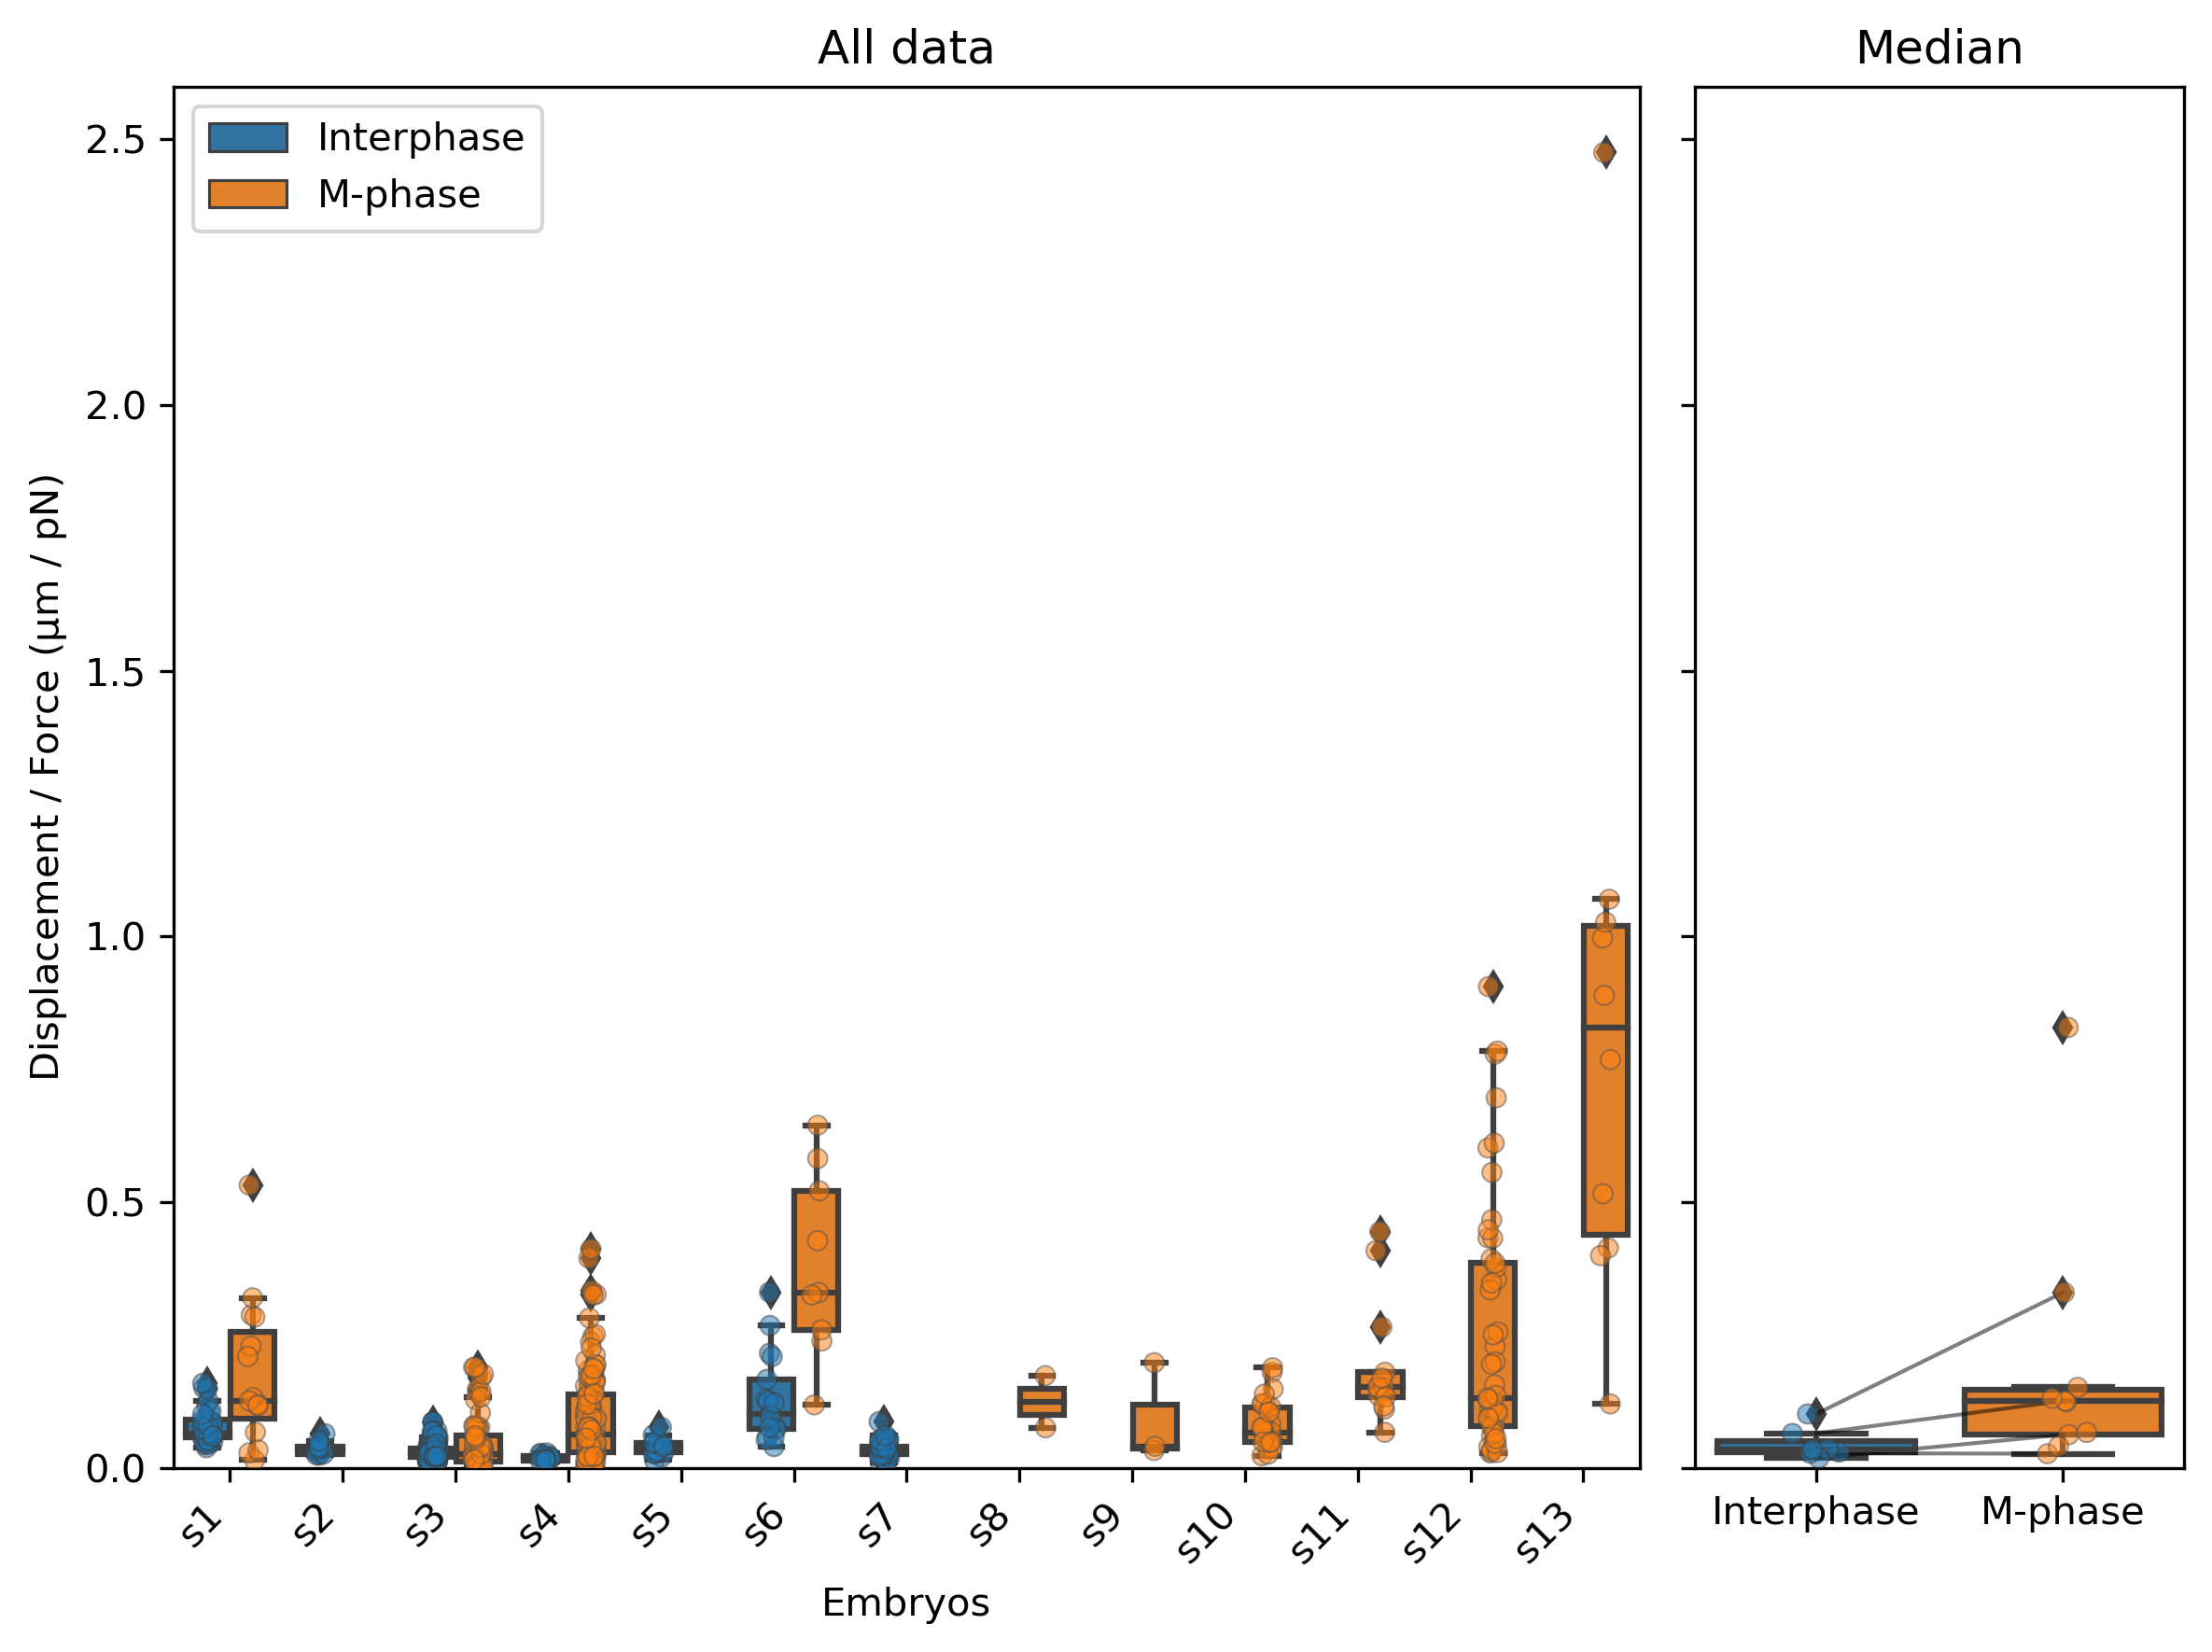

   MT_status       mean         std     median         q1         q3
16         y  34.557887   16.729946  33.059735  24.271933  38.778387
15         y  10.815205    6.084748   9.806136   5.989201  13.707265
14         y  29.658090   12.588325  27.673147  21.357756  33.643024
13         y  55.529848   13.849626  53.582015  43.840086  67.392157
12         y  39.921691   17.856531  35.579783  27.512624  48.541462
11         y  29.745556    7.911793  28.058422  25.003234  37.622070
10         y  14.504242    4.776543  15.309053  11.000515  17.290823
9          n   2.086973    2.278850   1.212710   0.980772   2.294849
0          n   9.454673    5.245158   9.454673   7.600229  11.309116
1          n  13.760252   17.328938   7.909091   3.937770  11.636986
7          n   9.741204    9.253455   7.613003   2.593800  12.719460
6          n   6.678920    3.218230   6.577687   5.541864   7.450969
5          n  38.296614  104.261292  15.889560   7.169165  33.761059
4          n  16.365664    9.08345

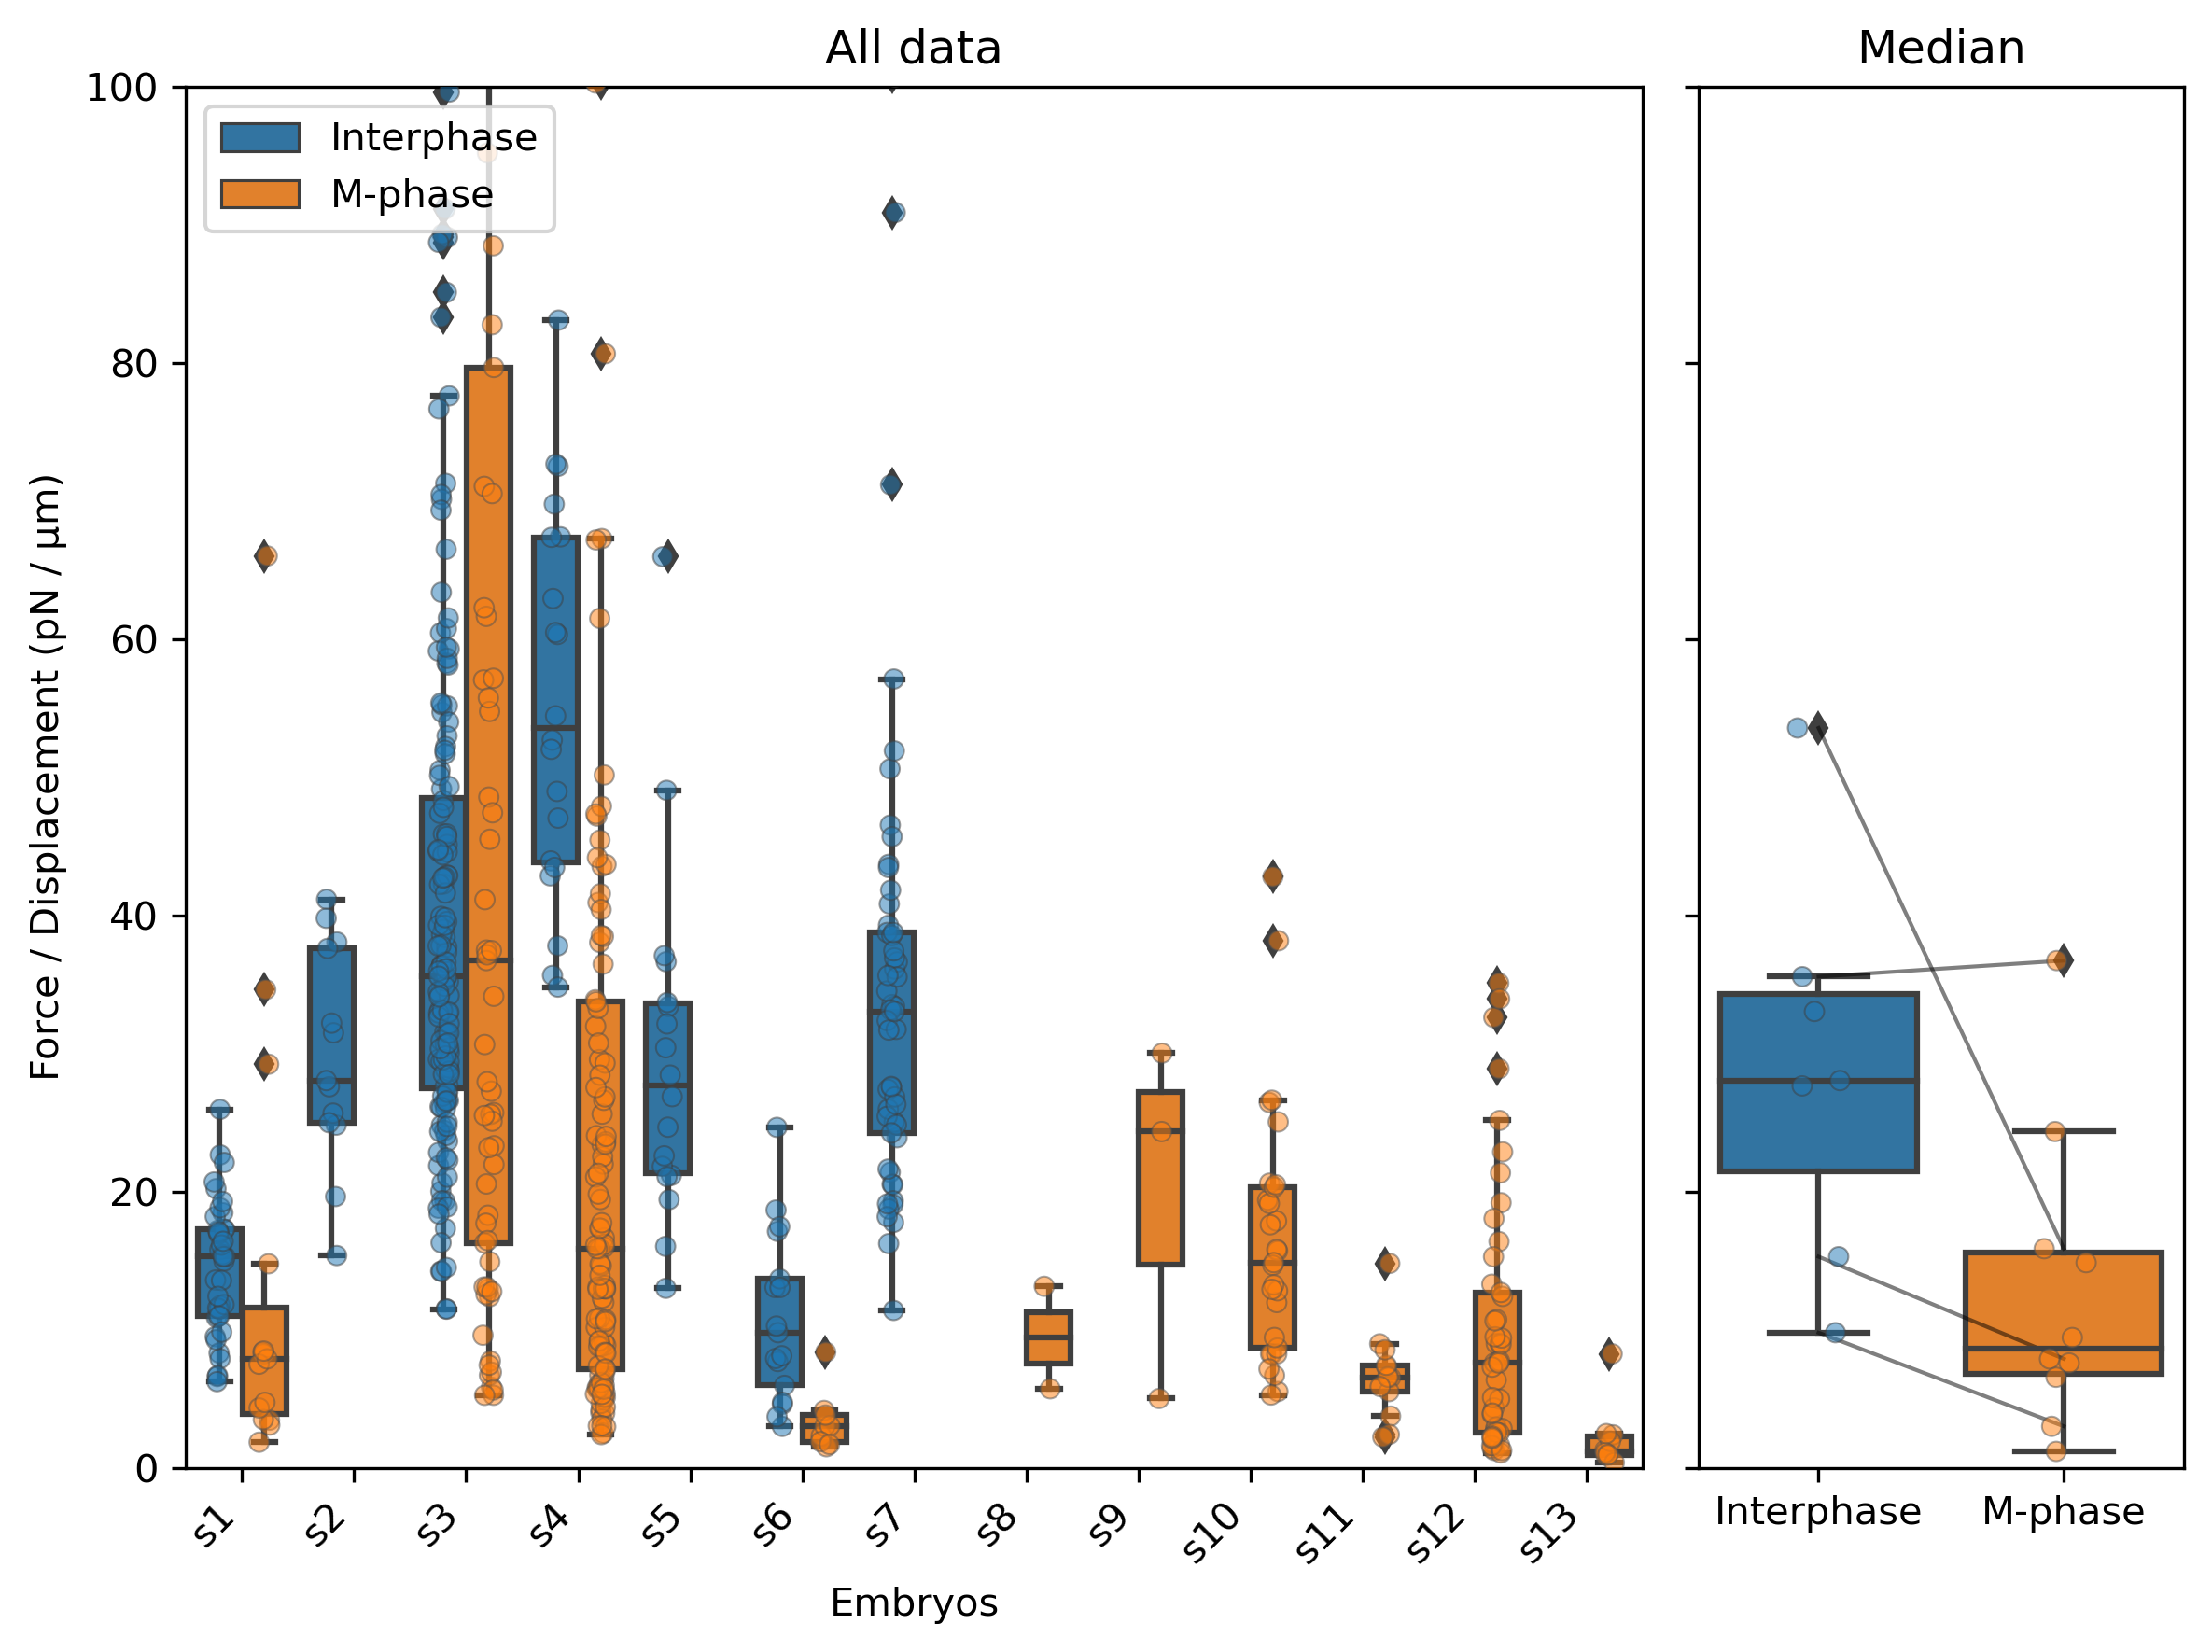

   MT_status      mean       std    median        q1        q3
16         y  0.491080  0.247335  0.462988  0.321976  0.692537
15         y  0.300255  0.151479  0.295096  0.181066  0.393646
14         y  0.573892  0.203259  0.547374  0.429348  0.667034
13         y  0.394149  0.168714  0.407187  0.285806  0.460932
12         y  0.346527  0.167746  0.330927  0.226676  0.443724
11         y  0.468867  0.187925  0.444286  0.338738  0.516030
10         y  0.360702  0.146866  0.337106  0.294576  0.437101
9          n  0.102172  0.107232  0.051988  0.030521  0.146669
0          n  0.042677  0.027766  0.042677  0.032861  0.052494
1          n  0.230196  0.165141  0.200161  0.077039  0.328835
7          n  0.175294  0.164731  0.119956  0.045334  0.281661
6          n  0.090459  0.108219  0.048865  0.032597  0.132111
5          n  0.225814  0.237243  0.127610  0.068272  0.273271
4          n  0.184650  0.099116  0.158532  0.108101  0.234193
3          n  0.275640  0.221279  0.220040  0.083078  0

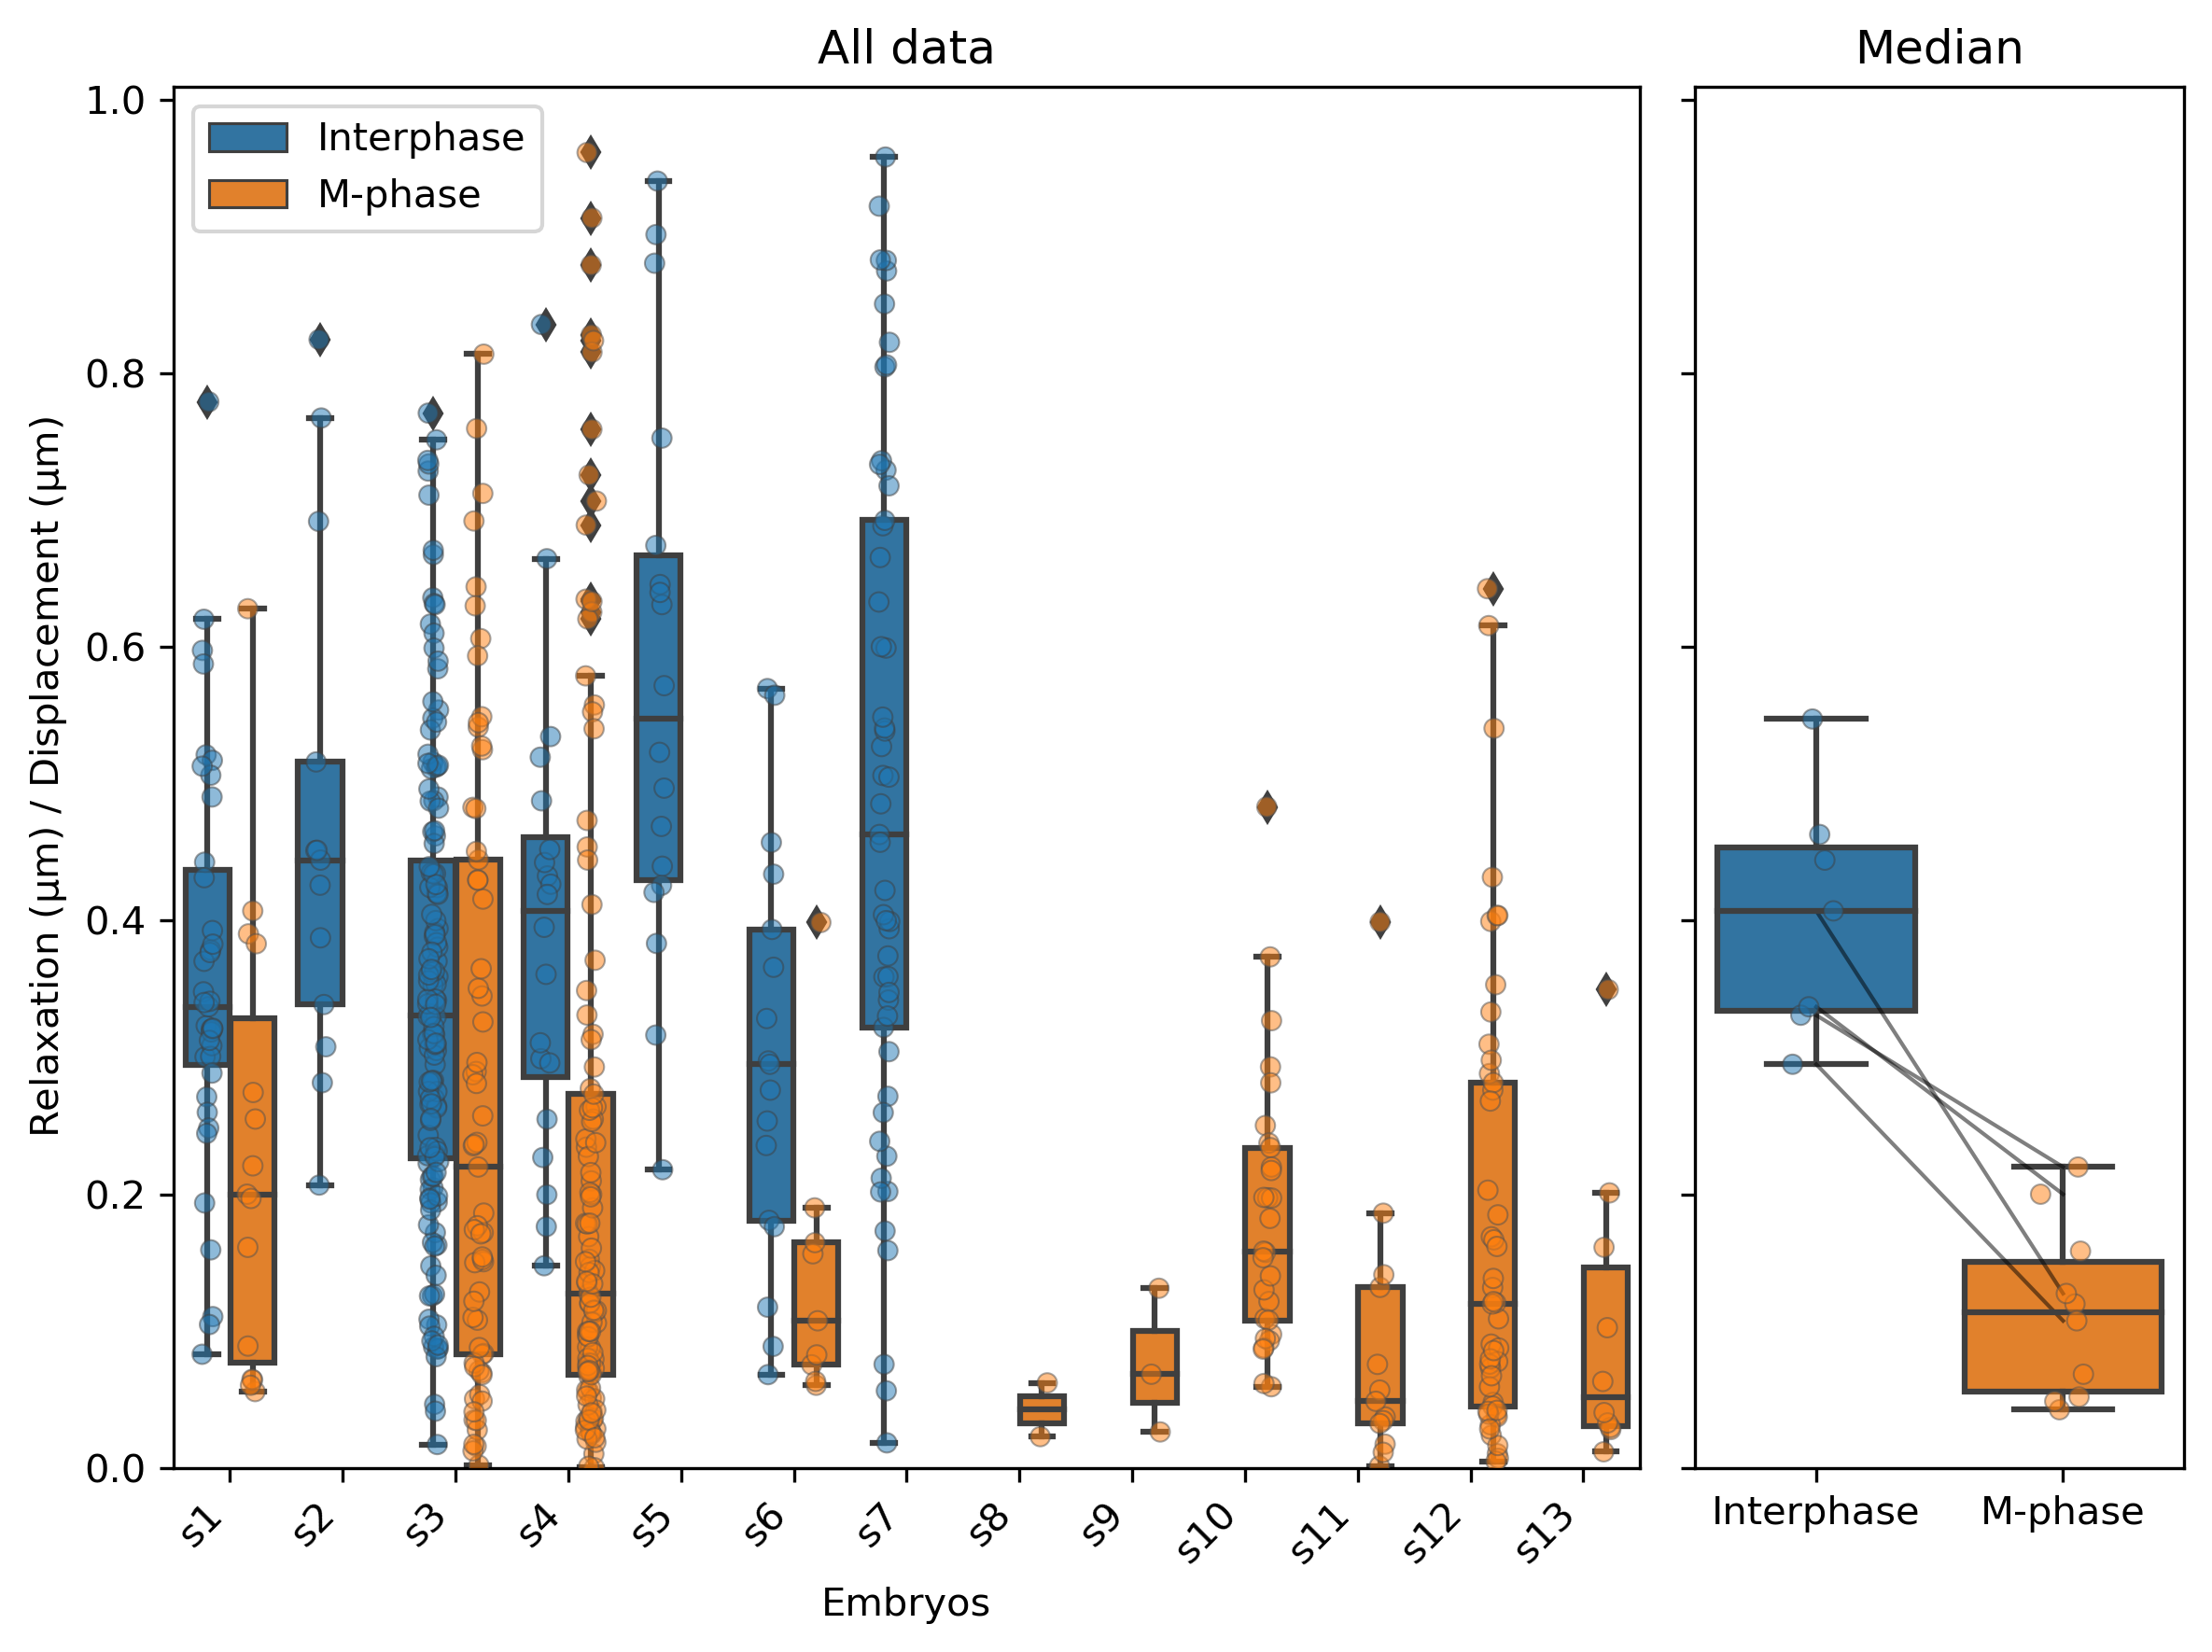

20240523s02p01 s0
Interphase
N =  39
M-phase
N =  15
20240614s02p02 s1
Interphase
N =  13
M-phase
N =  0
20240621s01p01 s2
Interphase
N =  148
M-phase
N =  65
20240621s02p02 s3
Interphase
N =  20
M-phase
N =  117
20240705s01p01 s4
Interphase
N =  18
M-phase
N =  0
20240705s02p01 s5
Interphase
N =  17
M-phase
N =  9
20240711s01p01 s6
Interphase
N =  53
M-phase
N =  0
20240523s01p01 s7
Interphase
N =  0
M-phase
N =  2
20240618s01p02 s8
Interphase
N =  0
M-phase
N =  3
20240621s02p01 s9
Interphase
N =  0
M-phase
N =  29
20240703s02p01 s10
Interphase
N =  0
M-phase
N =  13
20240703s03p01 s11
Interphase
N =  0
M-phase
N =  49
20240705s03p01 s12
Interphase
N =  0
M-phase
N =  10
20240711s01p01
['y']
20240705s03p01
['n']
20240705s02p01
['n' 'y']
20240705s01p01
['y']
20240703s03p01
['n']
20240703s02p01
['n']
20240621s02p02
['n' 'y']
20240621s02p01
['n']
20240621s01p01
['n' 'y']
20240618s01p02
['n']
20240614s02p02
['y']
20240523s02p01
['y' 'n']
20240523s01p01
['n']


In [5]:
folder = '/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/2_analysis/measurements_extended_info/'

df_results = pd.DataFrame(columns = ['exp_date', 'sample', 'position', 'embryo', 'rep', 'rising_dif', 'relaxing_dif', 'rising_dif_norm', 'relative_dif', 'MT_status'])

for idx in range(len(df_general_info)):
    filepath = df_general_info['trackmate_file'].values[idx]
    filename = os.path.basename(filepath).split('.')[0]
    file_h5 = f'{filename}_extended.h5'
    # load data to dataframe
    df = pd.read_hdf(folder + file_h5, key='df')
    df = df.sort_values(by='POSITION_T')

    # if 'exclude' in str(df_general_info['comments'].values[idx]):
    #     continue


    for track_id in df['TRACK_ID'].unique():
        track = df[df['TRACK_ID']==track_id]
        for pulse_n in track['PULSE_NUMBER'].unique():
            if pulse_n == 1:
                continue

            pulse = track[track['PULSE_NUMBER']==pulse_n]
            if not np.all(pulse['CORRECTED DISPLACEMENT [um]'].notna()):
                continue
            displacement = pulse['CORRECTED DISPLACEMENT [um]'].values

            rising_phase = pulse.loc[pulse['MAGNET_STATUS']==1, 'CORRECTED DISPLACEMENT [um]'].values
            rising_dif_norm = (rising_phase[-1]-rising_phase[0])/np.average(pulse.loc[pulse['MAGNET_STATUS']==1, 'FORCE [pN]'].values)
            rising_dif_norm_inverse = 1/rising_dif_norm

            rising_phase = pulse.loc[pulse['MAGNET_STATUS']==1, 'CORRECTED DISPLACEMENT [um]'].values
            rising_dif = rising_phase[-1]-rising_phase[0]
            rising_phase

            relaxing_phase = pulse.loc[pulse['MAGNET_STATUS']==0, 'CORRECTED DISPLACEMENT [um]'].values
            relaxing_dif = relaxing_phase[-1]-relaxing_phase[0]
            if (relaxing_dif < 0) and (rising_dif > 0) and (- relaxing_dif/rising_dif <= 1):
                new_line = {
                    'exp_date': [filename.split('_')[0]], 
                    'sample': [filename.split('_')[1][0:3]], 
                    'position': [filename.split('_')[1][3:6]], 
                    'embryo': [filename.split('_')[0]+filename.split('_')[1][0:6]],
                    'rep': [filename.split('_')[1][6:9]], 
                    'rising_dif': [rising_dif], 
                    'relaxing_dif': [relaxing_dif], 
                    'rising_dif_norm': [rising_dif_norm], 
                    'rising_dif_norm_inverse': [rising_dif_norm_inverse],
                    'relative_dif': [-relaxing_dif/rising_dif], 
                    'MT_status': [pulse['MT_STATUS'].values[0]]
                }

                df_results = pd.concat([df_results, pd.DataFrame(new_line)])

df_results.head()
df_results = df_results.sort_values(by=['MT_status', 'embryo'], ascending=[False, True])
# Define the mapping
mapping = {'y': 'Interphase', 'n': 'M-phase'}

# Create a new column based on the mapping
df_results['Phase'] = df_results['MT_status'].map(mapping)

df_median_stats = pd.DataFrame(columns=['mean', 'std', 'median', 'q1', 'q3', 'parameter'])
for (param, label) in zip(['rising_dif', 'relaxing_dif', 'rising_dif_norm', 'rising_dif_norm_inverse', 'relative_dif'], ['Displacement ($\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$)', 'Displacement / Force ($\mathrm{\\mu m}$ / pN)', 'Force / Displacement (pN / $\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$) / Displacement ($\mathrm{\\mu m}$)']):

    df = df_results

    # Calculate statistics
    stats = df.groupby(['MT_status', 'embryo'])[param].agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats = stats.reset_index()
    stats = stats.sort_values(by='MT_status', ascending=False)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 6), dpi=300, sharey=True, gridspec_kw={'width_ratios': [3, 1]})

    # First subplot: Combined boxplot and stripplot
    sns.boxplot(ax=axes[0], x='embryo', y=param, hue='Phase', data=df)
    sns.stripplot(ax=axes[0], x='embryo', y=param, hue='Phase', dodge=True, data=df, jitter=True, alpha=0.5, linewidth=0.5, legend=False)
    axes[0].set_xticks(ticks=range(len(df['embryo'].unique())))
    axes[0].set_xticklabels(labels=['s' + str(i+1) for i in range(len(df['embryo'].unique()))], rotation=45, ha='right')
    axes[0].set_ylabel(label)
    axes[0].set_xlabel('Embryos')

    # Add custom legend to the first plot
    axes[0].legend(loc='upper left')
    axes[0].set_title('All data')

    # Second subplot: Summary statistics
    sns.boxplot(ax=axes[1], x='MT_status', y='median', data=stats)
    sns.stripplot(ax=axes[1], x='MT_status', y='median', hue='MT_status', data=stats, jitter=True, alpha=0.5, linewidth=0.5, legend=False)
    axes[1].set_ylabel('')
    axes[1].set_xlabel('')
    axes[1].set_xticklabels(labels=['Interphase', 'M-phase'])
    axes[1].set_title(f'Median')

     # Calculate statistics
    stats_ = stats.drop(columns=['embryo'])
    print(stats_)
    stats_of_stats = stats_[['MT_status', 'median']].groupby(['MT_status']).agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats_of_stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats_of_stats['parameter'] = param
    stats_of_stats = stats_of_stats.reset_index()
    stats_of_stats = stats_of_stats.sort_values(by='MT_status', ascending=False)
    print(stats_of_stats)
    
    df_median_stats = pd.concat([df_median_stats, stats_of_stats])

    for embryo in stats['embryo'].unique():
        if len(stats.loc[stats['embryo']==embryo, 'median'].values) == 2:
            axes[1].plot(['y', 'n'], stats.loc[stats['embryo']==embryo, 'median'].values, 'k-', alpha = 0.5, linewidth=1)

    # Show the plots
    if param != 'relaxing_dif':
        plt.ylim(bottom=0)
    if param == 'rising_dif_norm_inverse':
        plt.ylim(top=100)
    plt.tight_layout()

    if save_to_server:
        plt.savefig(f'{results_dir}results/result_{param}.svg', format='svg')
    plt.show()

df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity median'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'median'].values) # in Pa.s median(eff_viscosity) = dt/(6*pi*r*median(rising_dif_norm))
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity mean'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'mean'].values) # in Pa.s mean(eff_viscosity) = dt/(6*pi*r*mean(rising_dif_norm))
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity q1'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'q1'].values) 
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity q3'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'q3'].values) 
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity std'] = np.multiply(df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'std'].values, np.divide(5/(6*np.pi*1.4),np.square(df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'median'].values))) # in Pa.s std(eff_viscosity) = std(rising_dif_norm)*dt/(6*pi*r*median(rising_dif_norm)**2)

if save_to_server:
    df_median_stats.to_csv(f'{results_dir}results/results_simple_analysis_stats_of_median.csv')

for (i, embryo) in enumerate(df['embryo'].unique()):
    print(embryo, f's{i}')
    print('Interphase')
    print('N = ', len(df[(df['embryo']==embryo)&(df['Phase']=='Interphase')]))
    print('M-phase')
    print('N = ', len(df[(df['embryo']==embryo)&(df['Phase']=='M-phase')]))

df = df.sort_values(by='embryo',ascending=False)
for embryo in df['embryo'].unique():
    print(embryo)
    print(df.loc[df['embryo']==embryo, 'MT_status'].unique())

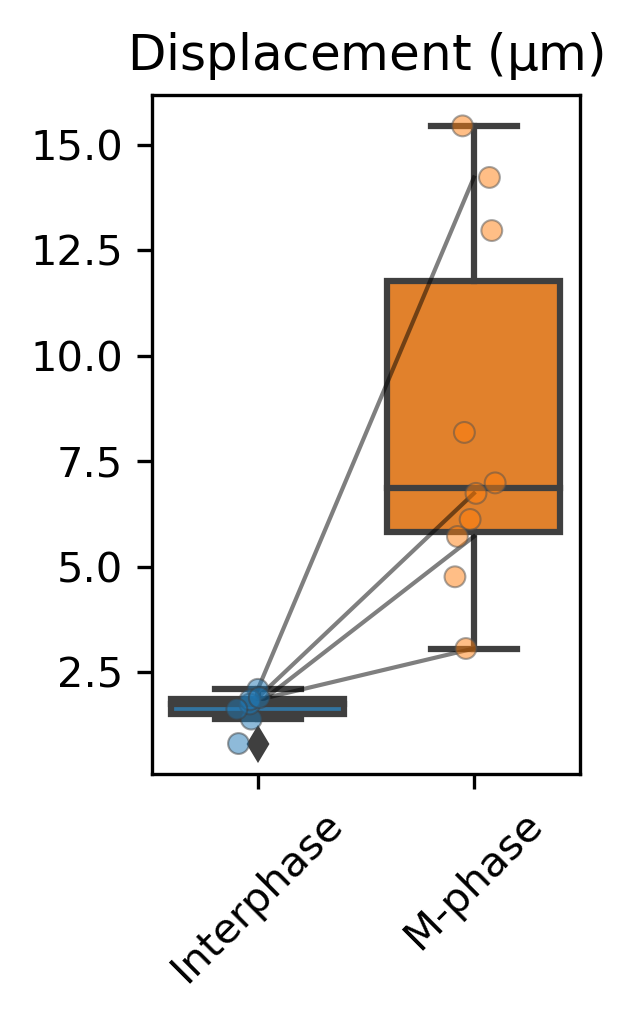

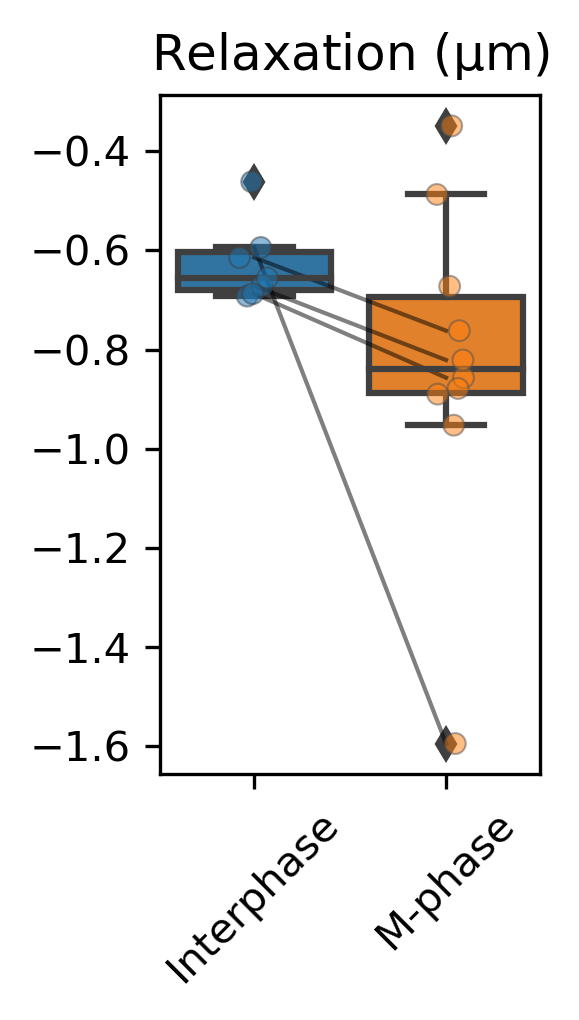

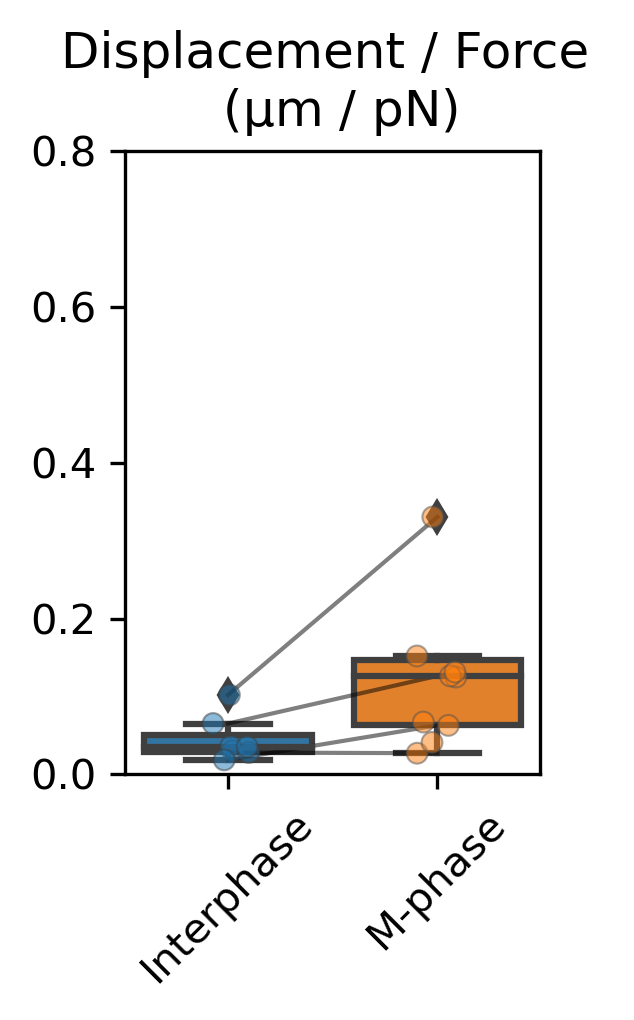

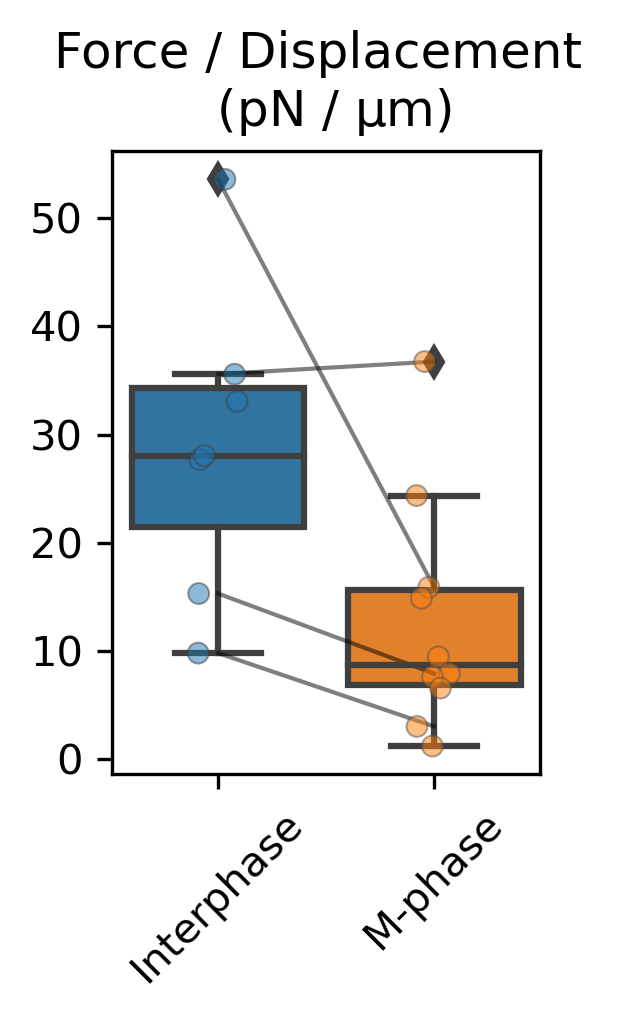

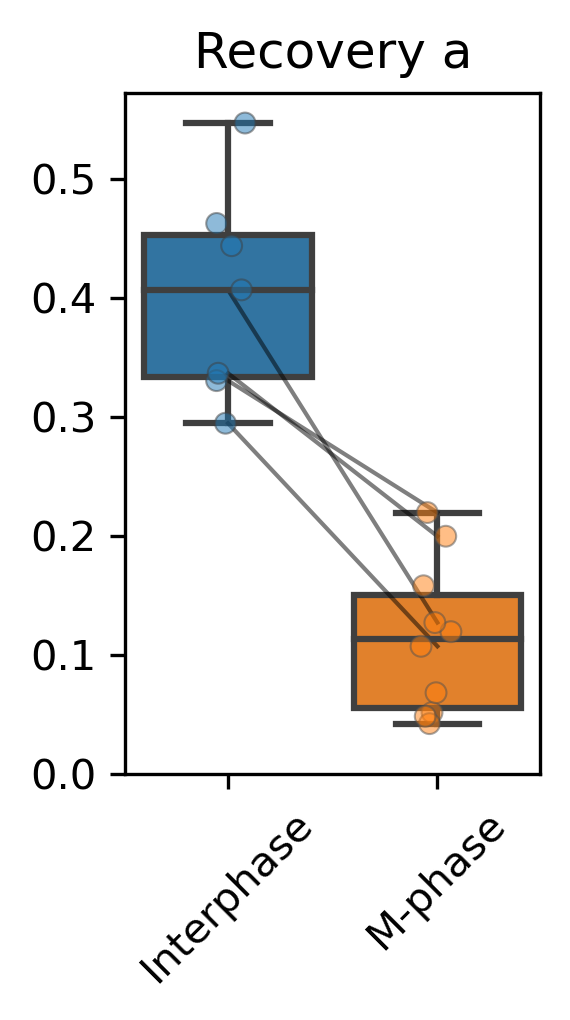

In [6]:
# Define the mapping
mapping = {'y': 'Interphase', 'n': 'M-phase'}

# Create a new column based on the mapping
df_results['Phase'] = df_results['MT_status'].map(mapping)


df_median_stats = pd.DataFrame(columns=['mean', 'std', 'median', 'q1', 'q3', 'parameter'])

for (param, label) in zip(['rising_dif', 'relaxing_dif', 'rising_dif_norm', 'rising_dif_norm_inverse', 'relative_dif'], ['Displacement ($\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$)', 'Displacement / Force \n ($\mathrm{\\mu m}$ / pN)', 'Force / Displacement \n (pN / $\mathrm{\\mu m}$)', 'Recovery a']):

    df = df_results

    # Calculate statistics
    stats = df.groupby(['MT_status', 'embryo'])[param].agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats = stats.reset_index()
    stats = stats.sort_values(by='MT_status', ascending=False)
    

    # Create subplots
    fig = plt.figure(figsize=(2, 3.5), dpi=300)

    # Second subplot: Summary statistics
    sns.boxplot(x='MT_status', y='median', data=stats)
    sns.stripplot(x='MT_status', y='median', hue='MT_status', data=stats, jitter=True, alpha=0.5, linewidth=0.5, legend=False)
    plt.title(f'{label}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(ticks = ['y', 'n'], labels=['Interphase', 'M-phase'], rotation=45)

    for embryo in stats['embryo'].unique():
        if len(stats.loc[stats['embryo']==embryo, 'median'].values) == 2:
            plt.plot(['y', 'n'], stats.loc[stats['embryo']==embryo, 'median'].values, 'k-', alpha = 0.5, linewidth=1)

    if param == 'rising_dif_norm':
        plt.ylim(0, 0.8)
    elif param == 'relative_dif':
        plt.ylim(bottom=0)
    
    
    plt.tight_layout()
    if save_to_server:
        plt.savefig(f'{results_dir}results/result_{param}_modelindependent_median.svg', format='svg')
    plt.show()